<a href="https://colab.research.google.com/github/mcppp/FinalProjectI2DL/blob/main/AUDIO_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir
from os.path import isfile, join
import csv
import numpy as np
from tqdm.notebook import tqdm  #for visualization
import sklearn
from sklearn import model_selection

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F   #for more detailed nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import sys
import librosa
from google.colab import drive
import soundfile
import subprocess

print(torch.__version__)

1.7.1+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# device = 'cpu'   #in runtime, change runtime type to CPU
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


In [4]:
#Loading data from npy arrays created by extracting audio features in the other notebook
feature_matrix=np.load('./drive/MyDrive/ABGABE I2DL/AUDIO_RAVDESS/feature_matrix.npy')  #modify the path as needed
sample_labels=np.load('./drive/MyDrive/ABGABE I2DL/AUDIO_RAVDESS/labels.npy') #modify the path as needed
fixed_labels = np.int64(sample_labels)-np.ones(len(sample_labels)) #adapting labels (they will start at label 0 instead of label 1)

print(feature_matrix.shape) #(1440, 193)
print(fixed_labels.shape) #(1440,)

(1440, 193)
(1440,)


In [5]:
#Splitting into train val set
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_matrix, fixed_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(type(X_train))
print(type(y_train))

(1152, 193)
(144, 193)
(144, 193)
(1152,)
(144,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
#Define dataset
class RAVDESS_Dataset(Dataset):
    def __init__(self, target_audio, target_label):
        
        self.target_audio = target_audio
        self.target_label = target_label
        self.num_data = target_audio.shape[0]  
        

    def __len__(self):
      return self.num_data
      
        
    def __getitem__(self, idx):
       sample = dict()
       sample['features'] =self.target_audio[idx]   # 'input'
       sample['label']= self.target_label[idx]  # 'output'

       return sample
        

In [7]:
#Define dataloader
batch_size = 256

# Define dataset for train, test, validation 
train_dataset = RAVDESS_Dataset(X_train,y_train)
test_dataset = RAVDESS_Dataset(X_test, y_test)
val_dataset = RAVDESS_Dataset(X_val, y_val)

#Checking type of dataset
print(type(train_dataset[0]['features']))
print(type(train_dataset[0]['label']))

# Define dataloader for train/test/val
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #we shuffle train data
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)


<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [8]:
class CNNs(nn.Module): #CNNs class inherits from nn.Module, in order to do gradient, forward automatically
    def __init__(self, channels= [64 , 128], dim_output=8):
        super(CNNs, self).__init__() 
        
        self.channels = channels 
        self.dim_output = dim_output

        self.conv1 = nn.Conv1d(1,self.channels[0], kernel_size=3, stride=1) 
        self.conv2 = nn.Conv1d(self.channels[0],self.channels[1], kernel_size=3, stride=1) 

        self.activation = nn.ReLU()
        
        self.flatten=nn.Flatten()

        self.fc1 = nn.Linear(24192, 24192//12)
        self.fc2 = nn.Linear(24192//12, self.dim_output)
      
        self.dropout = nn.Dropout(p=0.3)
        

    def forward(self, input_s):
        
       out = self.conv1(input_s)
       out = self.activation(out)
       out = self.dropout(out)
       out = self.conv2(out)
       out = self.activation(out)
       out = self.dropout(out)
       out = self.flatten(out)
       out = self.dropout(self.activation(self.fc1(out)))
       out = self.activation(self.fc2(out))
        
       return out

In [9]:
# Define the Model
model = CNNs() #defining hidden layer dimensions

#Define optimizer
optimizer = optim.Adam(model.parameters(), lr =1e-4)


In [10]:
#Printing model information
print(model)

CNNs(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=24192, out_features=2016, bias=True)
  (fc2): Linear(in_features=2016, out_features=8, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [11]:
def train(model, optimizer, sample):
    model.train()
    model = model.to(device)

    # Define the Loss for multi-class classification
    criterion = nn.CrossEntropyLoss() 
    
    # Clean up the Optimizer (delete gradient we had defined before)
    optimizer.zero_grad()

    # Set Input and Output
    features = torch.unsqueeze(sample['features'].float(),1).to(device)
    label = sample['label'].long().to(device) #label is idx of class that we have

    # Get prediction from the model    
    pred = model(features) #should give a a tensor with probabilities of the image belonging to each of the classes

    # Calculate number of correct prediction.
    num_correct = sum(torch.argmax(pred, dim=1) == label) #compare highest probability in the output tensor with the true label, add only correct predictions
    
    # Get the Loss from prediction and ground truth label
    pred_loss = criterion(pred,label.to(device)) 

    # Get the gradient (backprop), and update optimizer
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [12]:
def test(model, sample):
    model.eval()

    # Define the Loss for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Get the result without computing the gradient
    with torch.no_grad():
        # Set input and output
        features = torch.unsqueeze(sample['features'].float(),1).to(device)
        label = sample['label'].long().to(device)

        # Get prediction from the model    
        pred = model(features)

        # Calculate number of correct predictions
        num_correct = sum(torch.argmax(pred, dim=1) == label)

        # Get the Loss from prediction and ground truth label
        pred_loss = criterion(pred,label.to(device)) 

    return pred_loss.item(), num_correct.item(),pred

In [13]:
#Creating empty lists to save information to plot the train/val curve later
val_list =list()
train_list =list()
epochs_list = list()

In [14]:
#TRAINING AND VALIDATING

max_epoch = 1000


for epoch in tqdm(range(max_epoch)):  
    
   #############################Train Phase######################################
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0


    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample) #model optimized with that optimizer, sample enumerated from train_dataloader
        train_loss += curr_loss / len(train_dataloader)  #average loss value
        train_accu += num_correct / len(train_dataset)  #average accuracy

   
   #############################Validate Phase######################################
    
    # # Initialize Loss and Accuracy
    val_loss = 0.0
    val_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(val_dataloader):
        curr_loss, num_correct,_ = test(model, sample)
        val_loss += curr_loss / len(val_dataloader)
        val_accu += num_correct / len(val_dataloader)

      
    if epoch % 10 == 0: #saving information and printing train/validation accuracy every 10 epochs
      train_list.append(train_accu)
      val_list.append(val_accu)
      epochs_list.append(epoch)
      print(train_accu, val_accu)

0.11458333333333333 0.1180555555555556
0.1362847222222222 0.13888888888888892
0.14843749999999997 0.1666666666666667
0.16666666666666666 0.1666666666666667
0.16493055555555555 0.1805555555555556
0.1623263888888889 0.1805555555555556
0.1684027777777778 0.1805555555555556
0.18142361111111113 0.18750000000000006
0.2421875 0.2361111111111112
0.2517361111111111 0.25000000000000006
0.2534722222222222 0.24305555555555564
0.2664930555555556 0.2638888888888889
0.2630208333333333 0.25000000000000006
0.2586805555555556 0.25000000000000006
0.2664930555555556 0.25000000000000006
0.2612847222222222 0.2361111111111112
0.2734375 0.2569444444444445
0.2708333333333333 0.24305555555555564
0.4149305555555555 0.43055555555555497
0.42361111111111116 0.4374999999999994
0.43489583333333337 0.45138888888888823
0.4487847222222222 0.48611111111111033
0.5069444444444444 0.48611111111111033
0.6059027777777779 0.5347222222222213
0.6371527777777778 0.5416666666666657
0.6640625000000001 0.562499999999999
0.6970486111

(100,)
(100,)
(100,)


Text(0.5, 1.0, 'Train vs. Validation accuracy')

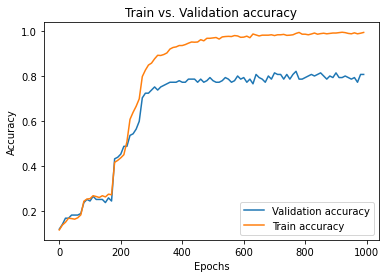

In [20]:
##Plotting train vs. validation accuracy curve
arr_epochs =np.array(epochs_list)
arr_val =np.array(val_list)
arr_train = np.array(train_list)
print(arr_epochs.shape)
print(arr_val.shape)
print(arr_train.shape)


f = plt.figure()
ax = f.add_subplot(111)
ax.plot(arr_epochs, arr_val,  label="Validation accuracy")
ax.plot(arr_epochs, arr_train,  label="Train accuracy")
ax.legend()

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs. Validation accuracy')

In [16]:
# ##Load already trained
# best_path=torch.load('./drive/MyDrive/ABGABE I2DL/AUDIO_RAVDESS/audio_best.pth')  ##modify the path as needed
# model.load_state_dict(best_path['model_state_dict'])

In [21]:
# Reporting accuracy on test set
test_loss = 0.0
test_accu = 0.0

    # Iterate over the val_dataloader
with tqdm(total=len(test_dataloader)) as pbar: # SUB PROGRESS BAR 2, up to 586 because that's the number of images in the 1 batch of val_dataloader
    for idx, sample in enumerate(test_dataloader): # for each of the 586 images
            curr_loss, num_correct,_ = test(model.to(device), sample)
            test_loss += curr_loss / len(test_dataloader) # average validation loss
            test_accu += num_correct / len(test_dataloader) # average accuracy
            pbar.update(1) # update SUB PROGRESS BAR 2
            
print(test_loss, test_accu)


0.9740806014329693 0.777777777777776


In [22]:
##Printing confusion matrix (reporting based on TEST SET)

nb_classes = 8
predictions= np.zeros(len(test_dataset))
labels= np.zeros(len(test_dataset))

with tqdm(total=len(test_dataloader)) as pbar:
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for idx, sample in enumerate(test_dataloader):
            labels[idx]=sample['label'].item()
            _, _, outputs = test(model, sample)
            _, preds = torch.max(outputs, 1)
            predictions[idx] = preds
            for t, p in zip(sample['label'].view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            pbar.update(1) # update SUB PROGRESS BAR 2

print(confusion_matrix)


tensor([[ 3.,  4.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0., 24.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., 11.,  2.,  0.,  3.,  0.,  0.],
        [ 0.,  1.,  0., 13.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  1., 16.,  1.,  0.,  0.],
        [ 0.,  1.,  1.,  1.,  0., 14.,  0.,  0.],
        [ 0.,  2.,  0.,  1.,  1.,  0., 14.,  1.],
        [ 1.,  0.,  2.,  1.,  3.,  1.,  0., 17.]])


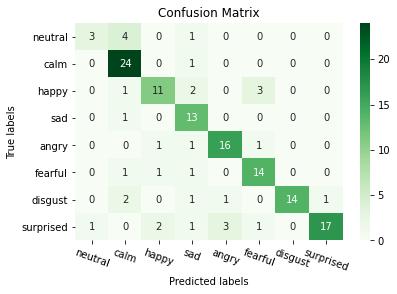

In [23]:
#Displaying confusion matrix as Heatmap

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
 
# labels, title and ticks
sns.heatmap(confusion_matrix, annot=True, ax = ax,fmt='g',cmap='Greens'); #annot=True to annotate cells
plt.yticks(rotation=0) 
plt.xticks(rotation=-20) 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]); ax.yaxis.set_ticklabels(["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]);